# Imports

In [133]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
# Maybe use https://gitlab.com/mike01/pypacker or https://stackoverflow.com/questions/30826123/python-scapy-vs-dpkt
import scapy
import pickle
import subprocess
from subprocess import PIPE
from pathlib import Path
from datetime import datetime, timedelta
from scapy.all import *
import networkx as nx
import matplotlib.dates as mdates
import statistics
import sharedVariables
from sharedVariables import *

In [118]:
# Datasets
dataset_sources = {
    'baseline': 'data\\20210910-baseline',
    'syncmesh': 'data\\20210910-syncmesh-gzip',
    'advanced': 'data\\20210913-advanced'
}


In [119]:
# Utility Functions
def to_human_readable(size, unit=True):
    power = 1000
    n = 0
    mem = {0 : 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /=  power
        n += 1
    if unit:
        return "{0:.2f} {1}".format(size, mem[n])
    else:
        return "{0:.2f}".format(size)

In [120]:
ip_seperator

'92.60.39.199'

In [121]:
def filterDataForSeperator(df): 
    df = df[df["ip.src"].isin([ip_seperator, ip_client])]
    df = df[df["ip.dst"].isin([ip_seperator, ip_client])]
    df = df[(df["tcp.dstport"] == 443) | (df["tcp.srcport"] == 443)]
    return df

def filterDataForLocalTraffic(df): 
    df = df[df["ip.src"].str.contains(r'^10\.')]
    df = df[df["ip.dst"].str.contains(r'^10\.')]
    return df

def loadDataSet(folder):
    df_base = None
    for filename in os.listdir(folder):
        if filename.endswith(".csv"):
            csvfile = os.path.join(Path.cwd(), folder, filename)
            print(csvfile)
            EPOCH = datetime(1900, 1, 1)
            currentdf = pd.read_csv(csvfile)

            currentdf["frame.time_epoch"] = currentdf["frame.time_epoch"].apply(lambda x: datetime.utcfromtimestamp(float(x)))

            currentdf.set_index('frame.time_epoch', inplace=True)

            currentdf.dropna(inplace=True)
            # currentdf = currentdf[currentdf["src"].str.contains(r'^10\.')]
            # currentdf = currentdf[currentdf["dst"].str.contains(r'^10\.')]
            
            # currentdf = currentdf[currentdf["sport"] != "ssh"]
            # currentdf = currentdf[currentdf["dport"] != "ssh"]
            if (df_base is None):
                df_base = currentdf
            else:
                df_base = df_base.append(currentdf)

        else:
            continue

    seperatordf = filterDataForSeperator(df_base)
    timings = seperatordf.index.values
    df_base = filterDataForLocalTraffic(df_base)
    return (df_base, timings)

datasets = {}
for source in dataset_sources:
    datasets[source] = loadDataSet(dataset_sources[source])
    
datasets["advanced"][1]

c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-baseline\10.1.0.11.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-baseline\10.1.0.2.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-baseline\10.1.0.3.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-baseline\10.2.0.12.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-baseline\10.3.0.13.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-syncmesh-gzip\10.1.0.11.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-syncmesh-gzip\10.1.0.2.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-syncmesh-gzip\10.2.0.12.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210910-syncmesh-gzip\10.3.0.13.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210913-advanced\10.1.0.11.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data\20210913-advanced\10.1.0.2.pcap.csv
c:\De

array(['2021-09-13T15:55:42.500574000', '2021-09-13T16:00:51.956609000',
       '2021-09-13T16:06:05.417157000', '2021-09-13T16:11:22.735764000',
       '2021-09-13T16:16:48.771456000', '2021-09-13T16:21:58.288717000',
       '2021-09-13T16:27:23.711565000', '2021-09-13T16:32:53.125134000',
       '2021-09-13T16:38:32.624529000'], dtype='datetime64[ns]')

In [122]:
def calcSubset(df):
    nodes = list(dict.fromkeys(df["ip.src"].unique().tolist() + df["ip.dst"].unique().tolist()))

    betweenNodesDataset = {}
    nodeCombinations = list(itertools.combinations(nodes, r=2))
    for combination in nodeCombinations: 
        # print(combination)
        # Use both src_ip and dest_ip as they are not request related
        betweenNodesDataset["between " + combination[0] + " and " + combination[1]] = df[df['ip.src'].isin(combination) & df['ip.dst'].isin(combination)]

    return betweenNodesDataset

node_datasets = {}
for key in datasets:
    node_datasets[key] = calcSubset(datasets[key][0])

setname = "baseline"
for key in node_datasets[setname]:
    print(key, ":", len(node_datasets[setname][key]))
    

between 10.1.0.11 and 10.1.0.3 : 3751
between 10.1.0.11 and 10.1.0.2 : 0
between 10.1.0.11 and 10.2.0.12 : 0
between 10.1.0.11 and 10.3.0.13 : 0
between 10.1.0.3 and 10.1.0.2 : 23906
between 10.1.0.3 and 10.2.0.12 : 11127
between 10.1.0.3 and 10.3.0.13 : 10528
between 10.1.0.2 and 10.2.0.12 : 0
between 10.1.0.2 and 10.3.0.13 : 0
between 10.2.0.12 and 10.3.0.13 : 0


In [123]:
# Experiments
def splitExperiments(df, timings):
    experiments = ["collect1", "collect7", "collect14", "collect30", "aggregate1", "aggregate7", "aggregate14", "aggregate30"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = calcSubset(df.loc[str(timings[index]):str(timings[index + 1])])
    return return_data

node_experiment_datasets = {}
for key in datasets:
    print(key)
    print(datasets[key][1])
    node_experiment_datasets[key] = splitExperiments(datasets[key][0], datasets[key][1])

setname = "baseline"
for key in node_experiment_datasets[setname]:
    print(key, ":", len(node_experiment_datasets[setname][key]))


baseline
['2021-09-10T14:11:48.519239000' '2021-09-10T14:15:10.921129000'
 '2021-09-10T14:18:40.100713000' '2021-09-10T14:22:15.684991000'
 '2021-09-10T14:26:04.677260000' '2021-09-10T14:29:26.349975000'
 '2021-09-10T14:32:52.069152000' '2021-09-10T14:36:21.590091000'
 '2021-09-10T14:39:59.545543000']


C:\Users\danie\AppData\Local\Temp/ipykernel_3924/1003008133.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  return_data[experiment] = calcSubset(df.loc[str(timings[index]):str(timings[index + 1])])


syncmesh
['2021-09-10T17:48:48.972582000' '2021-09-10T17:49:20.253011000'
 '2021-09-10T17:50:10.354010000' '2021-09-10T17:51:08.521481000'
 '2021-09-10T17:52:29.529649000' '2021-09-10T17:53:00.019064000'
 '2021-09-10T17:53:47.473976000' '2021-09-10T17:54:41.074398000'
 '2021-09-10T17:55:53.517972000']
advanced
['2021-09-13T15:55:42.500574000' '2021-09-13T16:00:51.956609000'
 '2021-09-13T16:06:05.417157000' '2021-09-13T16:11:22.735764000'
 '2021-09-13T16:16:48.771456000' '2021-09-13T16:21:58.288717000'
 '2021-09-13T16:27:23.711565000' '2021-09-13T16:32:53.125134000'
 '2021-09-13T16:38:32.624529000']
collect1 : 10
collect7 : 10
collect14 : 10
collect30 : 10
aggregate1 : 10
aggregate7 : 10
aggregate14 : 10
aggregate30 : 10


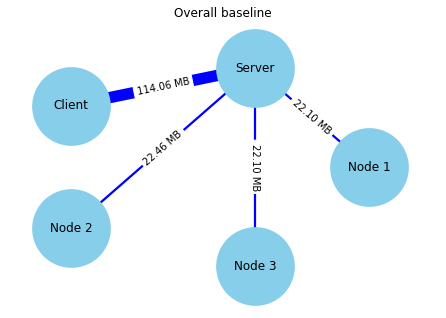

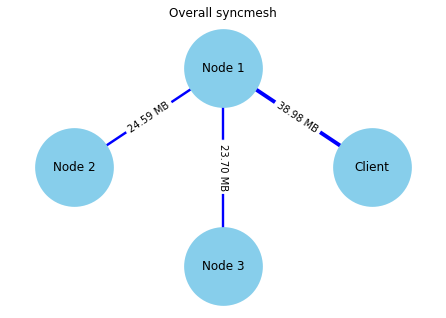

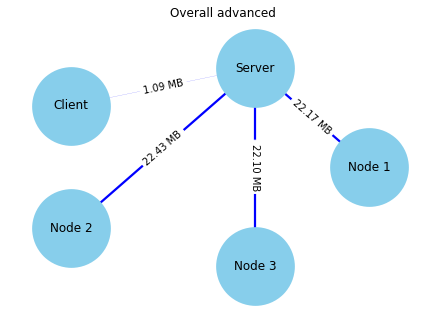

In [124]:
def get_node_name(ip):
    if(ip == "10.1.0.2"):
        return "Client"
    elif(ip == "10.1.0.3"):
        return "Server"
    elif(ip.startswith("10.")):
        return "Node " + ip.split(".")[1]
    return ip

for index, subset_key in enumerate(node_datasets):
    G = nx.Graph()
    # print(subset_key)
    for node_dataset_key in node_datasets[subset_key]: 
        subset = node_datasets[subset_key][node_dataset_key]
        # print(node_dataset_key) 
        if len(subset["ip.dst"]) > 0:
            G.add_edge(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]), color='b', weight=subset["ip.len"].sum()/10000000, label=to_human_readable(subset["ip.len"].sum()))

    pos = nx.circular_layout(G)

    plt.figure(index+1)
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
    nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="skyblue", node_shape="o", alpha=1, linewidths=40)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

    plt.axis('off')
    axis = plt.gca()
    axis.set_title("Overall " + subset_key)
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.savefig("out/network_"+subset_key+".png")
    

plt.show()

In [125]:
node_experiment_datasets["syncmesh"]["aggregate30"]['between 10.2.0.12 and 10.1.0.11'].to_csv("test.csv")
node_experiment_datasets["baseline"]["aggregate30"]['between 10.1.0.3 and 10.1.0.2'].to_csv("test2.csv")

0.43193835616438353
0.22703638876093965
147.6305576923077
125.3685625
0.16881844802342605
0.24886239999999996
147.70942519685036
125.28391468682507
0.27240072202166066
0.20266570367313247
150.06246485117163
132.69370457604307
0.30311128284389494
0.2095208998548621
147.89543938842374
125.2893718288527
0.5758813559322037
0.21937500000000001
147.77172857142853
125.84738461538458
0.2249647696476965
0.23739406286379514
147.85123128598852
125.21206088751293
0.19881508078994614
0.22820000000000001
145.4632214511041
125.14981719702098
0.2666277695716396
0.20982867132867133
147.857102189781
125.23253348641408
0.34155369127516777
154.1025
126.47249999999998
154.10337573099414
126.47363304093567
0.2972518978605934
154.1027593073593
126.47320072332732
0.28495331807780316
154.10310369540872
126.47387378870242
0.31066557572151143
154.1025
126.47487730061349
0.30815000000000003
154.10249999999996
126.47476277372263
0.28314999999999996
154.10314686825055
126.47337156995053
0.31455000000000005
154.1030

C:\Users\danie\AppData\Local\Temp/ipykernel_3924/2494268442.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(int(str(index)+str(e_index)))


0.22526492537313428
0.2254835873388042
147.70013714902808
125.34203919491527
0.2063324324324324
0.2374644107351225
145.45722513812157
125.5203386097729
0.16446190935390553
0.23898534583821804
147.7072412042075
125.36418005432672


{'baseline': {'collect1': {'between 10.1.0.11 and 10.1.0.3':                             tcp.analysis.initial_rtt       ip.id     ip.src  \
   frame.time_epoch                                                              
   2021-09-10 14:12:49.060401                  0.001874  0x0000ca31  10.1.0.11   
   2021-09-10 14:12:49.060424                  0.001668  0x00002628  10.1.0.11   
   2021-09-10 14:12:49.060580                  0.001668  0x00002629  10.1.0.11   
   2021-09-10 14:12:49.060654                  0.001874  0x0000ca32  10.1.0.11   
   2021-09-10 14:12:49.060751                  0.001668  0x000065cc   10.1.0.3   
   ...                                              ...         ...        ...   
   2021-09-10 14:12:49.096914                  0.000910  0x00005f53   10.1.0.3   
   2021-09-10 14:12:49.096989                  0.000910  0x000065ce   10.1.0.3   
   2021-09-10 14:12:49.097177                  0.000910  0x0000262c  10.1.0.11   
   2021-09-10 14:12:49.097205           

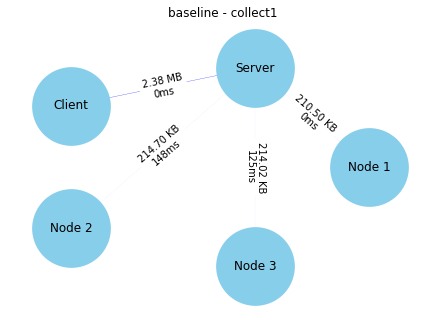

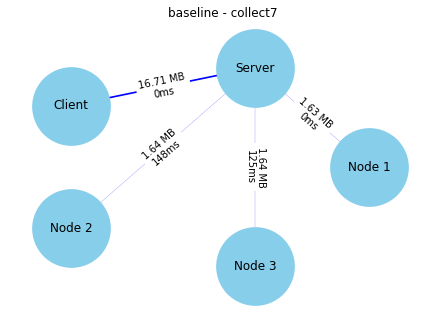

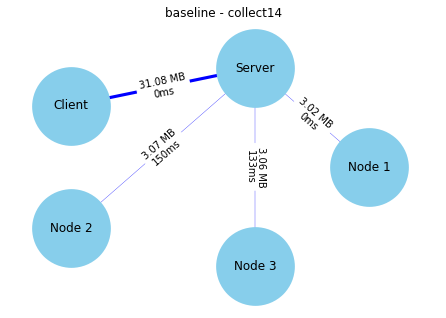

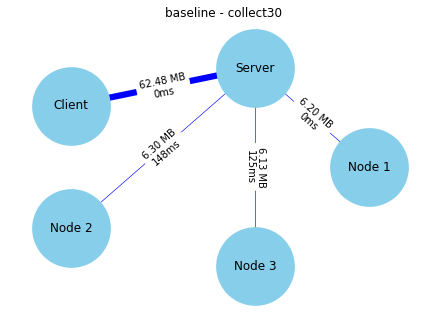

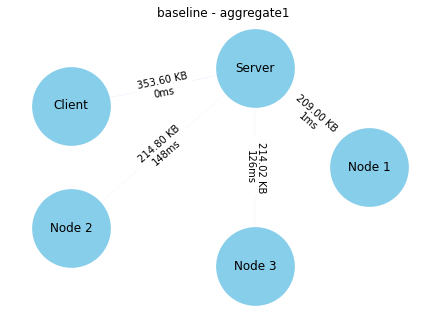

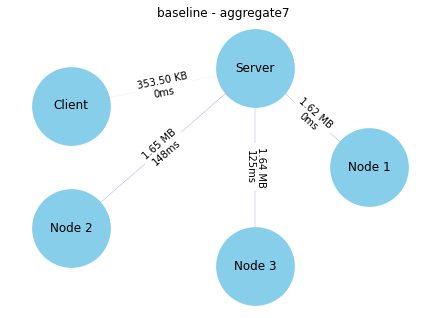

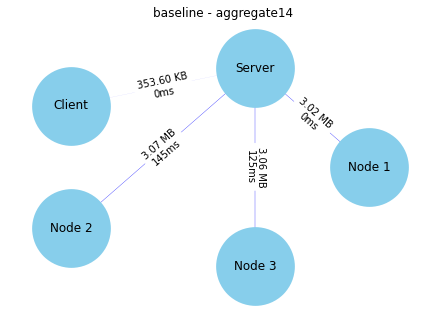

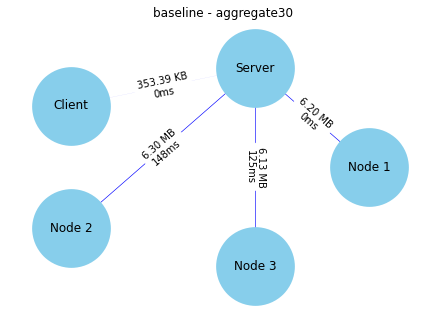

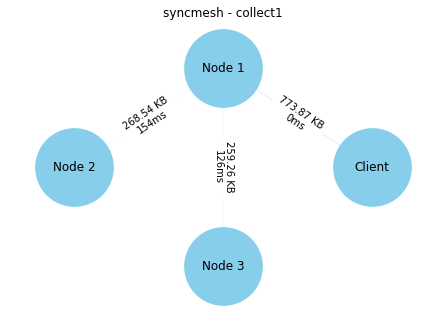

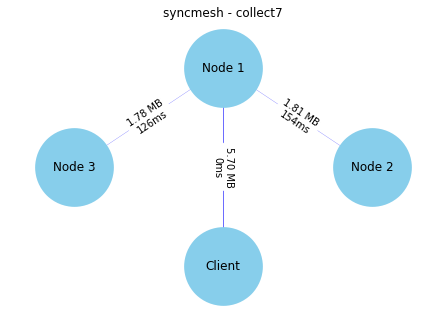

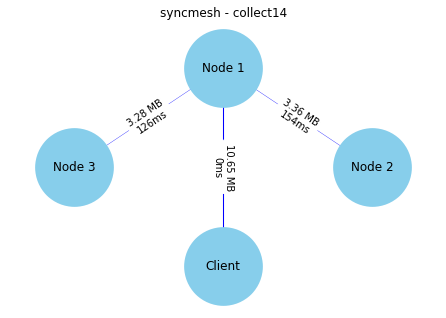

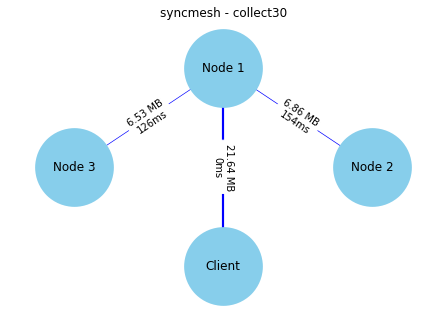

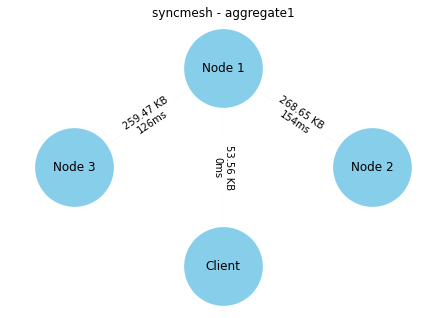

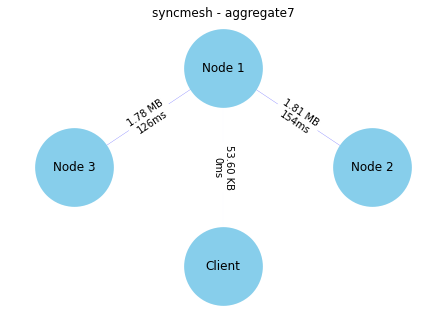

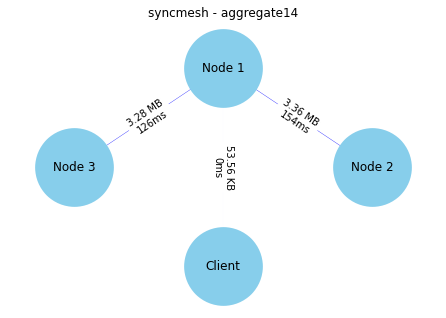

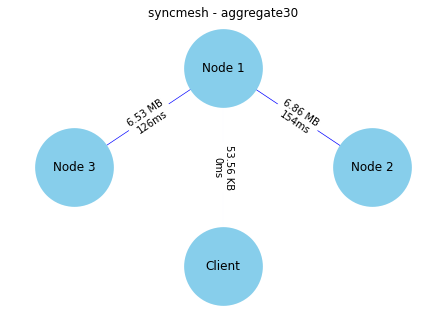

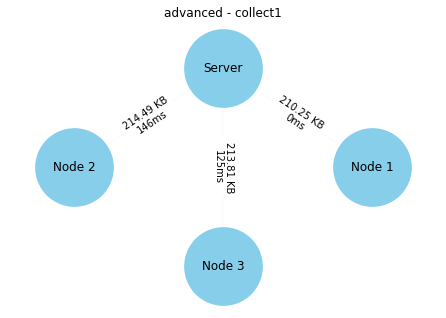

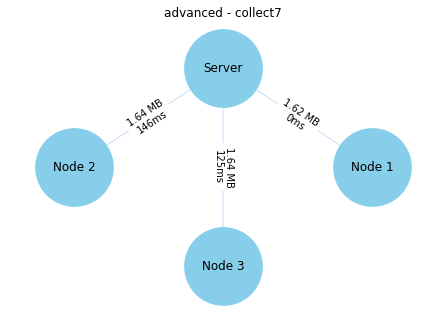

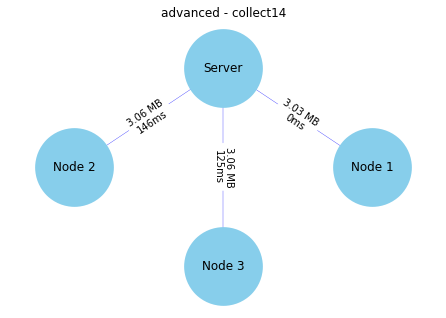

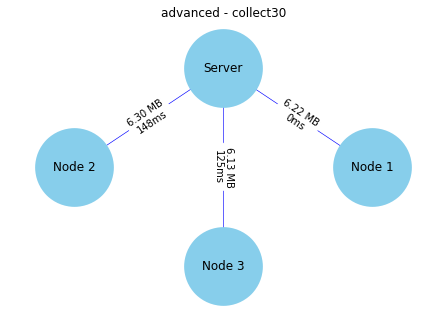

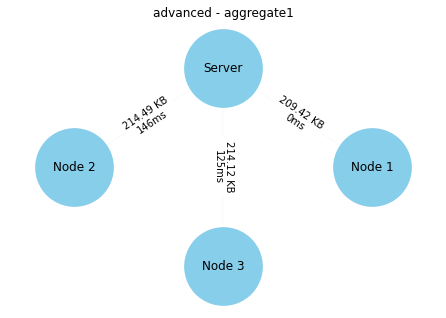

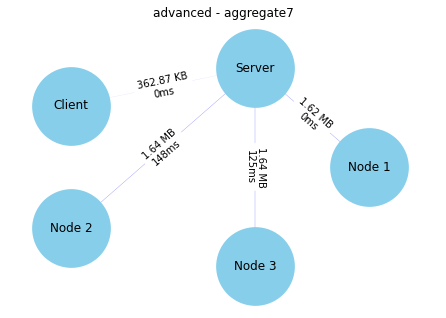

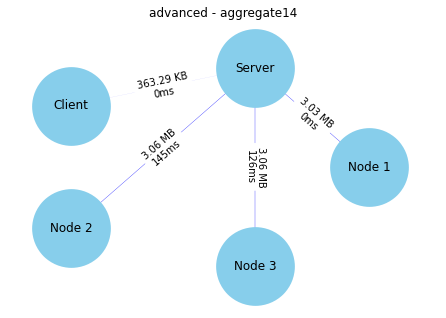

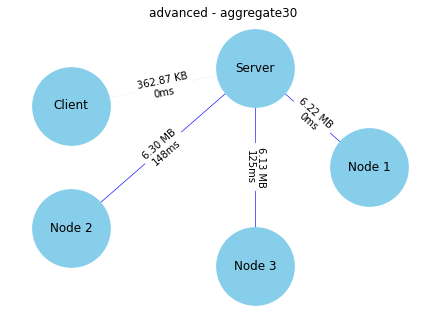

In [126]:
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        G = nx.Graph()
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            # print(node_dataset_key) 
            if len(subset["ip.dst"]) > 0:
                G.add_edge(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]), color='b', weight=subset["ip.len"].sum()/10000000, label=to_human_readable(subset["ip.len"].sum()) + "\n" + "{:.0f}".format(subset["tcp.analysis.initial_rtt"].mean()* 1000) + "ms")
                print(subset["tcp.analysis.initial_rtt"].mean()* 1000)

        pos = nx.circular_layout(G)

        plt.figure(int(str(index)+str(e_index)))
        edges = G.edges()
        colors = [G[u][v]['color'] for u,v in edges]
        weights = [G[u][v]['weight'] for u,v in edges]
        edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
        nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="skyblue", node_shape="o", alpha=1, linewidths=40)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

        plt.axis('off')
        axis = plt.gca()
        axis.set_title(subset_key + " - " + experiment_key)
        axis.set_xlim([1.2*x for x in axis.get_xlim()])
        axis.set_ylim([1.2*y for y in axis.get_ylim()])
        plt.savefig("out/network_"+subset_key+"-"+experiment_key+".png")

node_experiment_datasets
# plt.show()

In [127]:
from string import digits

s = 'abc123def456ghi789zero0'
remove_digits = str.maketrans('', '', digits)


subset_col = []
experiment_group_col = []
experiment_col = []
traffic_col = []
rtt_col = []
print("Aggregated Traffic")
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        subset_col.append(subset_key)   
        experiment_group_col.append(experiment_key.translate(remove_digits))
        experiment_col.append(experiment_key)
        sum_bytes = 0
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            sum_bytes = sum_bytes + subset["ip.len"].sum()

        traffic_col.append(sum_bytes)
        print(subset_key + " - " + experiment_key + ": " + to_human_readable(sum_bytes))

print("Median RTT")
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        rtt = np.array([])
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            rtt = np.append(rtt, subset["tcp.analysis.initial_rtt"].mean())

        # print(rtt)
        rtt_col.append(np.nanmean(rtt) * 1000)
        print(subset_key + " - " + experiment_key + ": " + str(np.nanmean(rtt) * 1000) + " msec " + str(statistics.median(rtt)))

Aggregated Traffic
baseline - collect1: 3.02 MB
baseline - collect7: 21.63 MB
baseline - collect14: 40.23 MB
baseline - collect30: 81.12 MB
baseline - aggregate1: 991.42 KB
baseline - aggregate7: 5.26 MB
baseline - aggregate14: 9.50 MB
baseline - aggregate30: 18.99 MB
syncmesh - collect1: 1.30 MB
syncmesh - collect7: 9.29 MB
syncmesh - collect14: 17.29 MB
syncmesh - collect30: 35.03 MB
syncmesh - aggregate1: 581.68 KB
syncmesh - aggregate7: 3.64 MB
syncmesh - aggregate14: 6.69 MB
syncmesh - aggregate30: 13.45 MB
advanced - collect1: 638.55 KB
advanced - collect7: 4.91 MB
advanced - collect14: 9.15 MB
advanced - collect30: 18.65 MB
advanced - aggregate1: 638.03 KB
advanced - aggregate7: 5.27 MB
advanced - aggregate14: 9.51 MB
advanced - aggregate30: 19.02 MB
Median RTT
baseline - collect1: 68.41452373430826 msec 0.06279779944438046
baseline - collect7: 68.35275518292472 msec 0.06276638854341253
baseline - collect14: 70.80780896322737 msec 0.0664481851398581
baseline - collect30: 68.4243

In [128]:
analyze_table = pd.DataFrame(dict(experiment=subset_col,
scenario=experiment_group_col,
                  scenario_nodes=experiment_col,
                  traffic=traffic_col,
                  rtt=rtt_col))



sum_table = analyze_table.groupby(["experiment", "scenario"]).agg(
    traffic=("traffic", "sum"), rtt_mean=("rtt", "mean"))


sum_table.to_latex('sum_table.tex',)
def our_sort(index):
    print(index)
    # if index.name == "subset":
    print(index)
    return index 



# sum_table["rtt_mean"] = sum_table["rtt_mean"].apply(lambda x: "{:.0f} ({:+.2%})".format(x,(1-sum_table["rtt_mean"][2] / x )))
# sum_table["traffic"] = sum_table["traffic"].apply(lambda x: to_human_readable(x, False) + " ({:+.2%})".format(1-(sum_table["traffic"][2] / x )))
sum_table = sum_table.unstack(level=-1).reindex(['baseline', 'advanced', 'syncmesh'])

extra_table = sum_table.copy()
extra_table.columns = ['.'.join(col).strip() for col in sum_table.columns.values]

for scenario in ["aggregate", "collect"]:
    extra_table["rtt_mean." + scenario] = extra_table["rtt_mean." + scenario].apply(lambda x: "{:.0f} ({:+.1%})".format(x,(1-extra_table["rtt_mean." + scenario][0] / x )))
    extra_table["traffic." + scenario] = extra_table["traffic." + scenario].apply(lambda x: to_human_readable(x, False) + " ({:+.1%})".format(1-(extra_table["traffic." + scenario][0] / x )))
extra_extra_table = extra_table.columns.str.split('.', expand=True)

extra_table.columns = extra_extra_table

extra_table.rename(columns={"traffic": "Traffic (in MB)", "rtt_mean": "RTT (in ms)"}, inplace=True)
extra_table.to_latex("sum_table.tex")
extra_table
# print([tuple(col.split("%")) for col in sum_table.columns.values])


Traffic (in MB)                   RTT (in ms)             
                 aggregate          collect    aggregate      collect
experiment                                                           
baseline     34.74 (+0.0%)   145.99 (+0.0%)   68 (+0.0%)   69 (+0.0%)
advanced     34.44 (-0.9%)  33.35 (-337.7%)   74 (+7.4%)  91 (+23.8%)
syncmesh    24.36 (-42.6%)  62.90 (-132.1%)  94 (+27.1%)  94 (+26.3%)

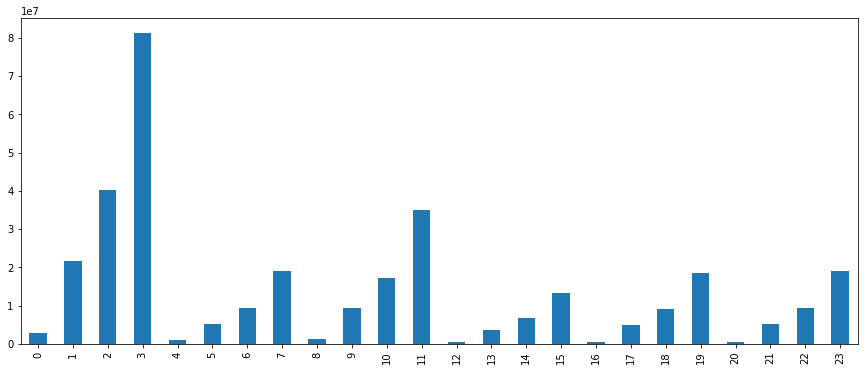

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

analyze_table['traffic'].plot.bar()

plt.show()
# This shows that the traffic is rising evenly accross multiple timeframes.

C:\Users\danie\AppData\Local\Temp/ipykernel_3924/3467378951.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


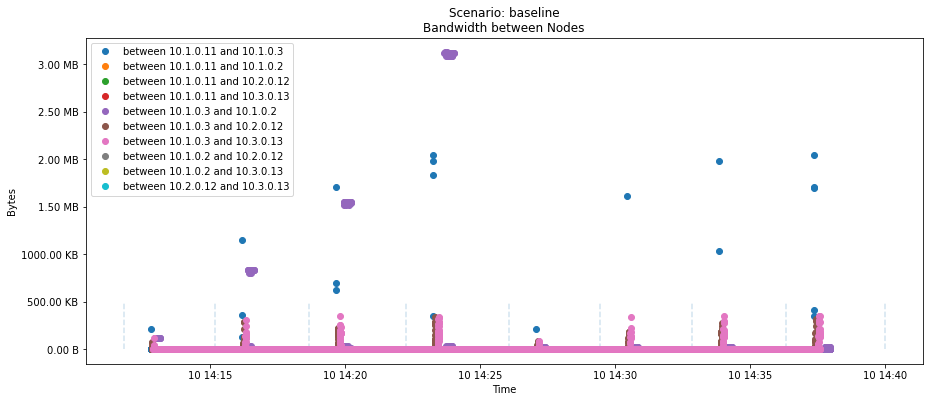

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="baseline"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

C:\Users\danie\AppData\Local\Temp/ipykernel_3924/4238307838.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


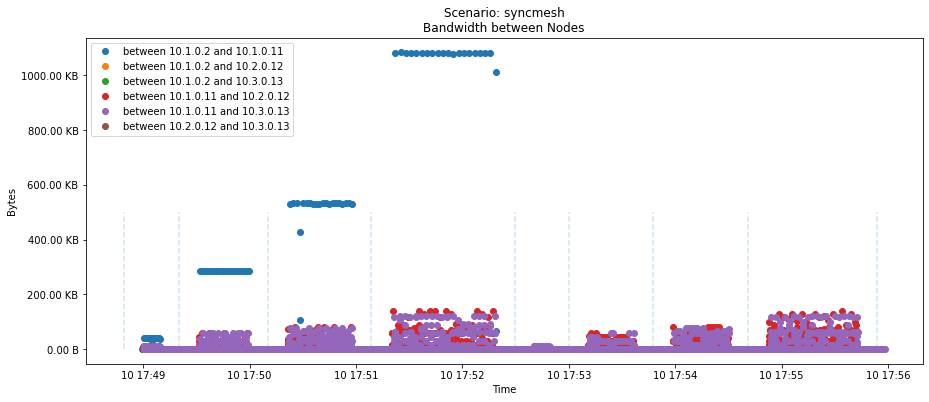

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ax.set_ylim(0,500)
dataset="syncmesh"
for key in node_datasets[dataset]: 
    test = node_datasets[dataset][key].resample('100ms').agg({"ip.len":'sum'})
    ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
# for key in fromClientDataset: 
#     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
#     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
# set title and legend

for timing in list(pd.to_datetime(datasets[dataset][1])): 
    ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
ax.set_title('Scenario: '+dataset+'\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left')

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

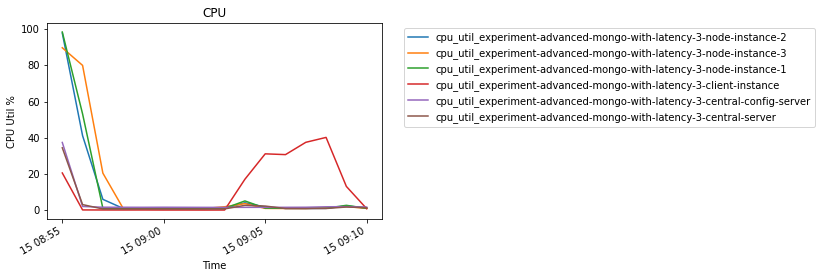

,cpu_util_experiment-advanced-mongo-with-latency-3-node-instance-2,io_read_experiment-advanced-mongo-with-latency-3-node-instance-2,io_write_experiment-advanced-mongo-with-latency-3-node-instance-2,iops_read_experiment-advanced-mongo-with-latency-3-node-instance-2,iops_write_experiment-advanced-mongo-with-latency-3-node-instance-2,cpu_util_experiment-advanced-mongo-with-latency-3-node-instance-3,io_read_experiment-advanced-mongo-with-latency-3-node-instance-3,io_write_experiment-advanced-mongo-with-latency-3-node-instance-3,iops_read_experiment-advanced-mongo-with-latency-3-node-instance-3,iops_write_experiment-advanced-mongo-with-latency-3-node-instance-3,...,cpu_util_experiment-advanced-mongo-with-latency-3-central-config-server,io_read_experiment-advanced-mongo-with-latency-3-central-config-server,io_write_experiment-advanced-mongo-with-latency-3-central-config-server,iops_read_experiment-advanced-mongo-with-latency-3-central-config-server,iops_write_experiment-advanced-mongo-with-latency-3-central-config-server,cpu_util_experiment-advanced-mongo-with-latency-3-central-server,io_read_experiment-advanced-mongo-with-latency-3-central-server,io_write_experiment-advanced-mongo-with-latency-3-central-server,iops_read_experiment-advanced-mongo-with-latency-3-central-server,iops_write_experiment-advanced-mongo-with-latency-3-central-server
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-09-15 09:10:00,0.013662,26897,1106729,1,90,0.010662,18375,1708252,1,181,...,0.017853,0,1420842,0,168,0.014412,65377,1311200,3,151
2021-09-15 09:09:00,0.024144,157676,1988899,12,201,0.020916,158330,1516107,10,146,...,0.020379,215548,1668404,30,202,0.018228,154716,1763095,19,206
2021-09-15 09:08:00,0.010873,122627,1113252,30,88,0.014236,130495,1196947,32,104,...,0.019398,300548,1633455,42,193,0.010000,87107,891047,21,63
2021-09-15 09:07:00,0.010594,0,1016362,0,71,0.010103,0,893534,0,58,...,0.016964,0,1301081,0,151,0.009394,0,756240,0,48
2021-09-15 09:06:00,0.010555,0,1595162,0,78,0.010101,0,1528636,0,83,...,0.016556,0,1232845,0,140,0.009854,16763,812208,0,50
2021-09-15 09:05:00,0.018268,775673,4701491,56,170,0.010580,531804,5769755,39,243,...,0.016487,0,1205929,0,131,0.023537,1916369,1915932,138,135
2021-09-15 09:04:00,0.041608,3831303,3901399,275,220,0.036982,4091556,2711654,296,127,...,0.016407,0,1295555,0,140,0.027519,2731188,2146424,198,156
2021-09-15 09:03:00,0.010274,0,844124,0,64,0.019650,0,864950,0,65,...,0.016215,0,1350511,0,149,0.007703,0,580304,0,42
2021-09-15 09:02:00,0.010086,4138,684038,0,51,0.009895,0,717411,0,56,...,0.016310,0,1242086,0,143,0.007529,0,497291,0,40


In [152]:
df = pd.read_csv("data/20210915-15/monitoring_experiment-advanced-mongo-with-latency-3.csv")
columns = df.columns
df.set_index('timestamp', inplace=True)
df = df.loc[str(pd.to_datetime("2021-09-15T09:10:00")):str(pd.to_datetime("2021-09-15T08:37:00"))]
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if col.startswith("cpu_"):
        ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('CPU')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()
df